In [1]:
import logging
logging.getLogger("kamene.runtime").setLevel(logging.ERROR)
from kamene.all import *
from pynq_networking import *
from math import log2 

A = 0.1 # Smoothing factor
WINDOW_SIZE = 10 # in seconds
OVERLAP = 0.5
INTERVAL_SEC = WINDOW_SIZE - WINDOW_SIZE*OVERLAP
PARAMS = ["src", "sport", "dport", "length"]
LOCALHOST = "192.168.1.6"
FILTER = "dst " + LOCALHOST +" and (tcp or udp)"

# Observed entropies
H = []
H_archive = [[] for i in range(len(PARAMS))]

# Predicted entropies
H_predict = [0,0,0,0]

# Parameters entropy prediction error
err = []

d = 0 # Anomaly score
d_archive = []

timeline = []

In [2]:
overlap_flows = [[] for i in range(int(OVERLAP/(1-OVERLAP)))]
overlap_flows_count = [[] for i in range(int(OVERLAP/(1-OVERLAP)))]
overlap_flows_pkts = [0 for i in range(int(OVERLAP/(1-OVERLAP)))]
current_flows = []
current_flows_count = []
current_flows_pkts = 0
def shift_flows():
    global overlap_flows
    global overlap_flows_count
    global overlap_flows_pkts
    global current_flows
    global current_flows_count
    global current_flows_pkts
    for i in range(len(overlap_flows)-1):
        overlap_flows[i] = overlap_flows[i+1]
        overlap_flows_count[i] = overlap_flows_count[i+1]
        overlap_flows_pkts[i] = overlap_flows_pkts[i+1]
    overlap_flows[len(overlap_flows)-1] = current_flows
    overlap_flows_count[len(overlap_flows)-1] = current_flows_count
    overlap_flows_pkts[len(overlap_flows)-1] = current_flows_pkts
    current_flows_pkts = 0
    current_flows = []
    current_flows_count = []

In [3]:
def packet_processing(packet):
    global current_flows_pkts
    global current_flows
    global current_flows_count
    
    if(IP in packet):
        current_flows_pkts = current_flows_pkts + 1
        #print('src: ',packet[IP].src, '; sport: ', packet[IP].sport, '; dport: ', packet[IP].dport, '; length: ', len(packet))
        flow = {'src': packet[IP].src, 'sport': packet[IP].sport, 'dport': packet[IP].dport, 'length': len(packet)}
        if(flow not in current_flows):
            current_flows.append(flow)
            current_flows_count.append(1)
        else:
            i = current_flows.index(flow)
            current_flows_count[i] = current_flows_count[i] + 1

In [4]:
def calc_entropy(param):
    global overlap_flows
    global current_flows_pkts
    
    values = []
    freqs = []
    for i in range(len(overlap_flows)):
        for j in range(len(overlap_flows[i])):
            if(overlap_flows[i][j][param] not in values):
                values.append(overlap_flows[i][j][param])
                freqs.append(overlap_flows_count[i][j])
            else:
                index = values.index(overlap_flows[i][j][param])
                freqs[index] = freqs[index] + overlap_flows_count[i][j]
    for i in range(len(current_flows)):
            if(current_flows[i][param] not in values):
                values.append(current_flows[i][param])
                freqs.append(current_flows_count[i])
            else:
                index = values.index(current_flows[i][param])
                freqs[index] = freqs[index] + current_flows_count[i]
    entropy = 0
    packets_in_window = sum(overlap_flows_pkts) + current_flows_pkts
    if(sum(freqs) != packets_in_window):
        print(freqs)
        print(packets_in_window)
    if(packets_in_window > 1):
        for i in range(len(freqs)):
            p = freqs[i] / packets_in_window
            entropy = entropy - p*log2(p)
        entropy = entropy / log2(packets_in_window) # Normalize entropy
    return entropy
    
def predict_entropy(param):
    global PARAMS
    global A
    global H_predict
    return H_predict[PARAMS.index(param)]*(1-A) + H[PARAMS.index(param)]*A
    
def calc_error(param):
    global PARAMS
    global H_predict
    return abs(H_predict[PARAMS.index(param)]-H[PARAMS.index(param)])

In [ ]:
# Preparation stage
for i in range(len(overlap_flows)):
    pkt_trace = sniff(iface="br0",
                      timeout = INTERVAL_SEC, filter=FILTER,
                      prn=lambda x: packet_processing(x))
    shift_flows()
    
pkt_trace = sniff(iface="br0",
                  timeout = INTERVAL_SEC, filter=FILTER,
                  prn=lambda x: packet_processing(x))
H = list(map(calc_entropy, PARAMS))
H_predict = list(map(predict_entropy, PARAMS))

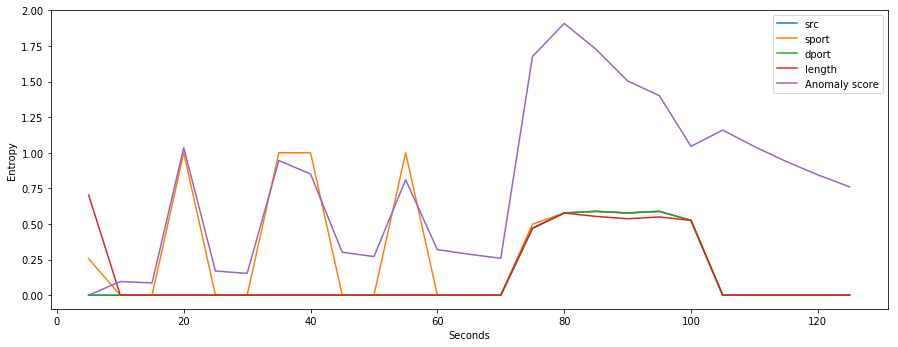

In [ ]:
import matplotlib.pyplot as plt 
from IPython.display import clear_output

while(True):
    clear_output(wait=True)
    for i in range(len(PARAMS)):
        plt.plot(timeline, H_archive[i], label=PARAMS[i]);
    plt.plot(timeline, d_archive, label='Anomaly score')
    plt.legend(loc='best')
    plt.ylabel('Entropy')
    plt.xlabel("Seconds")
    plt.rcParams["figure.figsize"] = (15,5.5)
    plt.show()
    
    shift_flows()
    pkt_trace = sniff(iface="br0",
                      timeout = INTERVAL_SEC, filter=FILTER,
                      prn=lambda x: packet_processing(x))
    if(len(timeline) == 0):
        timeline.append(INTERVAL_SEC)
    else:
        timeline.append(timeline[-1]+INTERVAL_SEC)
    for i in range(len(PARAMS)):
        H_archive[i].append(H[i])
    d_archive.append(d)
    
    H = list(map(calc_entropy, PARAMS))
    err = list(map(calc_error, PARAMS))
    d = sum(err)
    H_predict = list(map(predict_entropy, PARAMS))